## pset 07: _the adventure of the elusive motif_

In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

rng = np.random.default_rng(10212024)    # fixed RNG seed for reproducibility

## 1. Implement EM

I'll start with how I'll initialize the algorithm. I'll use a strategy of choosing a random posterior probability distribution for motif location, then calling the same `increment_counts()` routine that I use in the main iteration of the algorithm. Various different strategies work here. I want the initial guess to be "reasonable" (not a bunch of super-extreme probabilities), with some chance of seeing a shadow of the most abundant w-mers in the sequences. I also want the initialization to be stochastic, so I can run the EM local optimizer more than once and get different optima.

In [2]:
def initialize(rng, X, W):
    """Make a random starting motif of width W.

    We initialize by choosing a random motif position distribution for each X[i], 
    then collecting counts and converting to probabilities. The
    background is counted everywhere there isn't a motif.

    Input:
    rng     random number generator
    X       list of digitized seqs
    W       motif width

    Return:
    motif   random starting motif, as probabilities. motif[k][a] for position k=0..W-1, residue a=0..3
    bg      random starting background probabilities, bg[a]
    """
    motif = np.zeros((W,4))
    bg    = np.zeros(4)
    n     = len(X)

    for s in range(n):
        L = len(X[s])
        P = rng.dirichlet(np.ones(L-W+1))      # samples a P(m|x) motif location distribution randomly
        increment_counts(motif, bg, X[s], P)
    return(reestimate(motif, bg))

Most of the probability algebra work is in inferring the posterior distribution of motif locations, given the model. So I'll write that function next. I'll precalculate  log_2 probability parameters in `motifsc` and `bgsc` from `motif` and `bg` probability models before calling this function.

I call the motif position `m` in my code, where I called it $\lambda$ in the lecture notes. `lambda` is a reserved keyword in Python that can't be used as a variable name, alas.

In [3]:
def position_postprobs(motifsc, bgsc, x):
    """Calculate posterior prob P(m | x, motif, bg) for motif position m in seq x.
    
    Input:
    motifsc[k][a] log_2 probabilities. k=0..W-1 positions;  a=0..3 A|C|G|T
    bgsc[a]       log_2 background probabilities
    x[i]          digitized sequence array (residues as 0..3), i=0..L-1 positions

    Returns:
    P[m]          Probabilities P(m | x, motif, bg) of start points m [m = 0..K-W]
    totP          Marginal probability P(x | motif, 

    """
    W = len(motifsc)
    L = len(x)

    P = np.zeros( L-W+1 )
    for m in range(L-W+1):  # For each possible start position m = 0..L-W:
        P[m] = 0.                                            # Calculate log P(x, m | motif, bg)
        for i in range(m):      P[m] += bgsc[x[i]]           #     .. 0..m-1 terms
        for k in range(W):      P[m] += motifsc[k][x[m+k]]   #     .. m..m+W-1 terms for the motif
        for i in range(m+W, L): P[m] += bgsc[x[i]]           #     .. m+W..L-1 terms
    logPx  = logsumexp2(P)        # Normalization of probabilities stored as log probs uses logsumexp
    P      = np.exp2(P - logPx)   # Now P is P(m | x, motif, bg), from P(x,m|.) / \sum_m P(x,m|.), calculated as exp2(log_2 P(x,m|.) - logsumexp2( log P(x,m|.)))
    return P, logPx               # and totP is log_2 P(x | motif, bg)


In that code, I needed to do the logsumexp trick in log_2 space, since I'm using log base 2 (bits) everywhere. So now I need to roll my own logsumexp2().

In [4]:
def logsumexp2(log2p):
    """Calculate and return logsumexp in bits of a log_2 probability vector.
    """
    max = np.max(log2p)
    return max + np.log2(np.sum(np.exp2(log2p - max)))   # note it's not just log_2, it's also a 2^x with that exp2(x) call

After calculating posterior probabilities for the unknown motif positions, I use that distribution to increment the counts in a new model.

In [5]:
def increment_counts(newmotif, newbg, x, P):
    """Increment expected counts in motif, bg using start distribution P(m|x,.) for sequence x

    Input:
    newmotif[0..W-1][a]    for collecting expected counts in a new motif model
    newbg[a]               for collecting expected background counts
    x[0..L-1]              target digital sequence
    P[0..L-W]              P(m | x, prv_motif, prv_bg) posteriors for position

    Returns:
    newmotif and newbg are incremented in-place.
    """
    W = len(newmotif)
    L = len(x)
    for m in range(L-W+1):
        for i in range(m):     newbg[x[i]]         += P[m]
        for k in range(W):     newmotif[k][x[m+k]] += P[m]
        for i in range(m+W,L): newbg[x[i]]         += P[m]

Once I have expected counts for a new motif and bg, I'll convert those counts to probabilities.

In [6]:
def reestimate(newmotif, newbg):
    """Given estimated counts in newmotif|newbg, convert in-place to estimated probabilities.

    Also returns the new motif, bg to allow for an idiom of
        motif, bg = reestimate(newmotif, newbg)
    """
    W = len(newmotif)
    for k in range(W):
        Z = np.sum(newmotif[k])
        newmotif[k] = np.divide(newmotif[k], Z)

    Z = np.sum(newbg)
    newbg = np.divide(newbg, Z)
    return newmotif, newbg


Now I have all the pieces for an EM algorithm. 

I'm not too fussed here about optimizing how I decide on convergence. I'll just do what I think is an excessive number of iterations, and check the curve of increasing log probability of the data to make sure it looks like it was asymptoting.

In [7]:
def EM(rng, X, W, be_verbose=False):
    """Use EM to find a motif PWM and a bg, given motif width W and observed digital sequences X.

    Returns (motif, bg, tot_logP, progress)
    motif     (W,4) array of p_k(a) probabilities
    bg        f(a) background probabilities
    tot_logP  log P(X | theta) of the final model parameters
    progress  list of log P(X | theta) at each iteration: for plotting convergence, comparing across EM runs
    """
    n = len(X)
    motif, bg = initialize(rng, X, W)  
    progress  = []

    for epoch in range(500):                    # max 500 iterations, if it doesn't meet the convergence test
        newmotif = np.zeros((W,4))
        newbg    = np.zeros(4)
        tot_logP = 0
        motifsc  = np.log2(motif)
        bgsc     = np.log2(bg)
        for s in range(n):
            P, logPx  = position_postprobs(motifsc, bgsc, X[s])
            tot_logP += logPx
            increment_counts(newmotif, newbg, X[s], P)
        motif, bg = reestimate(newmotif, newbg)
        progress.append(tot_logP)

        # convergence test
        if epoch >= 1: delta = (prv_logP - tot_logP) / prv_logP     # delta is positive, the way I ordered that calculation. tot_logP > prv_logP, and both are negative
        else:          delta = 1
        if be_verbose:
            print('    iteration {:2d}  log_2 P(X) {:.2f} bits   motif score {:.2f} bits   delta={:.2g}'.format(epoch+1, tot_logP, relentropy(motif, bg), delta))
        if delta < 1e-6: break                       # I dialed in my choice for threshold by running positive controls with many iterations
        prv_logP = tot_logP

    # Calculate tot_logP one last time, with the final model
    motifsc  = np.log2(motif)
    bgsc     = np.log2(bg)
    tot_logP = 0
    for s in range(n):
        P, logPx  = position_postprobs(motifsc, bgsc, X[s])
        tot_logP += logPx
    progress.append(tot_logP)
    return motif, bg, tot_logP, progress

EM is a local optimizer, so now I'll write a wrapper that runs the algorithm a few times from different starting points and keeps the best,
where "best" is defined as highest log probability of the data.

In [8]:
def multi_EM(rng, X, W, n_tries, be_verbose=False):
    """Do several runs of EM from different starting points and keep the best.

    Returns (motif, bg, tot_logP, progress)
    motif     (W,4) array of p_k(a) probabilities
    bg        f(a) background probabilities
    tot_logP  log P(X | theta) of the best final model
    progress  (n_tries, n_epochs+1) list of lists of log P(X | theta) for each run, for plotting convergence
    """
    best_logP    = -np.inf
    all_progress = []

    for t in range(n_tries):
        if be_verbose: 
            print('run {:2d} start'.format(t+1))
        (motif, bg, tot_logP, progress) = EM(rng, X, W, be_verbose=be_verbose)
        if tot_logP > best_logP:
            best_motif = motif
            best_bg    = bg
            best_logP  = tot_logP
        all_progress.append(progress)
        if be_verbose:
            print('run {:2d} complete.  log_2 P(X) {:.2f} bits   motif score {:.2f} bits'.format(t+1, tot_logP, relentropy(motif, bg)))
    return best_motif, best_bg, best_logP, all_progress        

I'll want to calculate the relative entropy (Kullback-Leibler divergence) of each motif I find, as a measure of its "strength".

In [9]:
def relentropy(motif, bg):
    W = len(motif)

    KL = 0.
    for k in range(W):
        for a in range(4):
            KL += motif[k][a] * (np.log2(motif[k][a]) - np.log2(bg[a]))
    return KL

And finally, I'll want some simple visualization of the inferred motif, and the convergence of the EM runs.

For visualizing the motif, I'll heatmap the $\log_2 \frac{p_k(a)}{f(a)}$ log likelihood ratios, because I'm interested in discriminating the motif from background sequence, not just in motif probabilities alone. I set the heat map so any negative score is blank, and I'm just visualizing the strength of LLR's above zero.

In [10]:
def visualize(motif, bg, all_progress):
    fig,(ax1,ax2) = plt.subplots(1,2, layout='tight')
    motifsc = np.log2(motif) - np.log2(bg)
    ax1.imshow(motifsc.T, cmap='Blues', vmin=0, vmax=np.max(motifsc))
    ax1.set_title(r'motif consensus $\log_2 \frac{p_k(a)}{f(a)}$')
    ax1.set_xlabel('position')
    ax1.set_xticks(range(len(motif)))
    ax1.set_xticklabels([ k+1 for k in range(len(motif)) ] )
    ax1.set_yticks([0,1,2,3])
    ax1.set_yticklabels(list('ACGT'))
    for t in range(len(all_progress)):
        ax2.plot(all_progress[t])
    ax2.set_title('EM convergence')
    ax2.set_xlabel('iteration')
    ax2.set_ylabel('log_2 P(x), bits')

    np.set_printoptions(precision=3, suppress=True)  # suppress=True makes printing an np.array always use fixed-point, not sci notation
    print('Motif probabilities:')
    print(motif)
    print('')
    print('Background probabilities:')
    print(bg)
    print('')
    print('Inferred motif has relative entropy of {:.2f} bits'.format(relentropy(motif, bg)))

That completes my EM implementation.

When I get to the final section, I'll need a routine for reading Lestrade's FASTA data files. I'll put that here.

In [11]:
def read_fasta(file):
    """Read set of DNA sequence(s) from FASTA <file>, digitizing them.

    A digital sequence is a list of values 0..A-1 for alphabet size A,
    or -1 for invalid residue. Values are the index in <alph>: 0=A,
    1=C, 2=G, 3=T for 'ACGT'.

    Input:
    file    name of FASTA file to read
    alph    alphabet residues; 'ACGT'

    Returns:
    X       array of digital sequences. len(X) is the number of seqs;
            len(X[0]) is the length of the 1st seq in residues.
    """
    X    = []
    seq  = []
    alph = 'ACGT'
    with open(file) as f:
        for line in f:
            if line.startswith('>'): 
                if len(seq) > 0:
                    X.append(seq)
                    seq = []
            else:
                seq += [ alph.find(x) for x in line.strip().upper() ]
    if len(seq) > 0:
        X.append(seq)
    return X


## 2. Do a synthetic positive control

The synthetic positive control sequences each have one embedded motif, at a random position.

I want the motif result to be easily interpretable, so I'll make the known motif in a simple way by providing a consensus sequence (e.g. 'GATTACA'), and then making a PWM from that by assigning some probability p to each consensus base, and probability (1-p)/3 to the other three bases, at each position.

In [12]:
def positive_control_data(rng, consensus, p, bg, N, L):
    """Generate a positive control dataset of N digitized sequences of length L.

    Each sequence has one motif planted in it at a random position. <consensus> 
    defines the motif consensus sequence and width, as a string e.g. 'GATTACA'.
    <p> defines the probability of the consensus residue at each position of the
    motif model, and other residues get probability (1-p)/3.

    The remaining sequence (outside the motif) is generated i.i.d. with background
    frequencies given by <bg>.

    Example:
        X = positive_control_data(rng, 'GATTACA', 0.7, [0.25]*4, 200, 50)
    """
    # Make the motif probabilities from <consensus> and <p>
    W = len(consensus)
    motif = np.array( [(1.0-p)/3] * W * 4 ).reshape(W,4)
    for k in range(W):
        motif[k][ 'ACGT'.find(consensus[k]) ] = p
    print('Embedded positive control motif has relative entropy of {:.2f} bits'.format(relentropy(motif, bg)))

    # Make the digital positive control sequences, by planting motif in iid background
    X = []
    for s in range(N):
        x   = rng.choice(range(4), L, p=bg)     # generate iid random seq of length L
        pos = rng.integers(L-W+1)               # choose random motif position
        M   = [ rng.choice(range(4), p=motif[k]) for k in range(W) ]  # sample a motif
        x[pos:pos+W] = M                                              # plant the motif
        X.append(x)
    return X

Now make a positive control data set of N=200 sequences of length L=50, with uniform background composition, embedding a motif 'GATTACA' with probability 0.7 for each consensus base.

In [13]:
N  = 200
L  = 50
bg = [0.25]*4

X_pos = positive_control_data(rng, 'GATTACA', 0.7, bg, N, L)

Embedded positive control motif has relative entropy of 4.50 bits


Run EM on it!

I can pass a flag `be_verbose=True` to get my EM functions to output reassuring information as they go. I used this when I was developing. Here I've let it stay off, now that I know it works.

I'll make W a little bigger, because it's better to find the true motif in a slightly longer inference, as opposed to missing a piece of the true motif.

In [14]:
n_tries = 3
W       = 8
(motif, bg, logP, all_progress) = multi_EM(rng, X_pos, W, n_tries, be_verbose=False)

Motif probabilities:
[[0.12  0.081 0.694 0.104]
 [0.707 0.059 0.154 0.08 ]
 [0.072 0.124 0.066 0.738]
 [0.11  0.095 0.082 0.712]
 [0.68  0.073 0.086 0.161]
 [0.072 0.766 0.116 0.046]
 [0.678 0.07  0.107 0.144]
 [0.329 0.208 0.27  0.194]]

Background probabilities:
[0.257 0.242 0.251 0.25 ]

Inferred motif has relative entropy of 4.85 bits


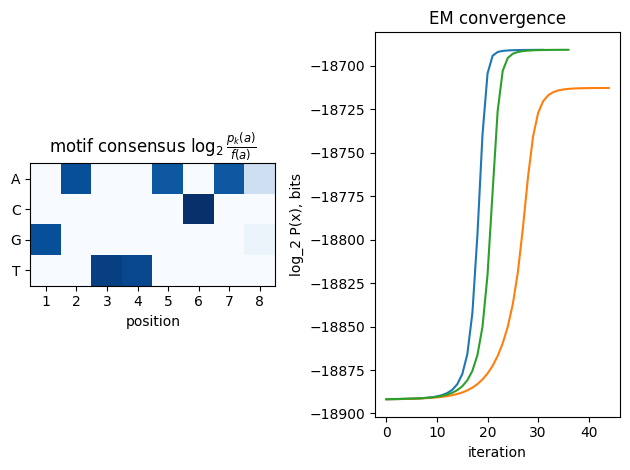

In [15]:
visualize(motif, bg, all_progress)

That looks fine. EM successfully identified my 7nt positive control consensus GATTACA in its 8nt window.

The inferred probabilities of the consensus GATTACA residues are all reasonably close to the known 0.7 I set the positive control to.

The relative entropy of the inferred motif is a little higher than the true motif, but that's not surprising. The W=8 made it look for a wider motif than the true W=7, and it finds some extra score in the noise of the extra position (as well as elsewhere).


## 3. Do a synthetic negative control

Here's one typical negative control. I could (and did) play around with N, L, and the background probabilities.

In [16]:
N  = 200
L  = 50
bg = [0.25]*4

X_neg = rng.choice(range(4), (N,L), p=bg)     # yeah it's that easy

The EM runs take longer on negative control data - it struggles to find signal in data that's all noise. Running this cell takes a while.

In [17]:
n_tries = 3
W       = 8
(motif, bg, logP, neg_progress) = multi_EM(rng, X_neg, W, n_tries, be_verbose=False)

Motif probabilities:
[[0.021 0.097 0.442 0.44 ]
 [0.264 0.38  0.004 0.352]
 [0.149 0.11  0.434 0.308]
 [0.033 0.103 0.349 0.515]
 [0.252 0.282 0.008 0.458]
 [0.513 0.251 0.081 0.155]
 [0.182 0.394 0.171 0.252]
 [0.146 0.246 0.605 0.003]]

Background probabilities:
[0.261 0.26  0.241 0.238]

Inferred motif has relative entropy of 3.10 bits


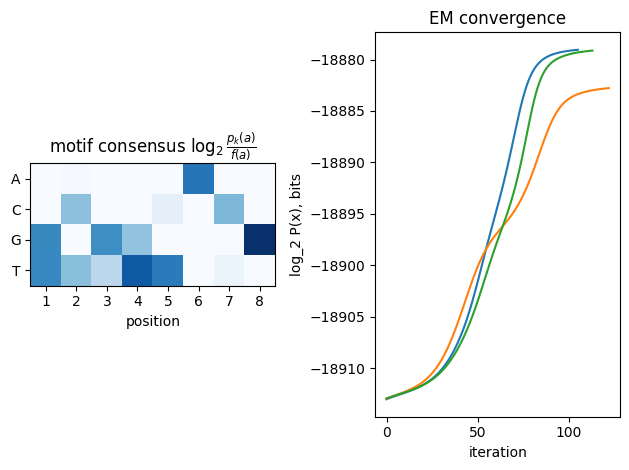

In [18]:
visualize(motif, bg, neg_progress)

It can always find _something_!

If we did enough negative control runs, we could build up an empirical null distribution for motif relative entropy scores, and evaluate the statistical significance of a relative entropy score when we analyze real data. But that would take a lot of compute power, so I didn't attempt it here.

## 4. find the ribosome binding sites in Lestrade's phage

Set some parameters shared by all three analyses:

In [19]:
ntries = 3
W      = 7

and here we go...

### AluminumJesus

Motif probabilities:
[[0.016 0.172 0.785 0.027]
 [0.371 0.012 0.575 0.041]
 [0.687 0.019 0.152 0.141]
 [0.035 0.133 0.832 0.   ]
 [0.106 0.141 0.675 0.078]
 [0.458 0.078 0.175 0.289]
 [0.071 0.285 0.573 0.071]]

Background probabilities:
[0.216 0.348 0.256 0.179]

Inferred motif has relative entropy of 5.17 bits


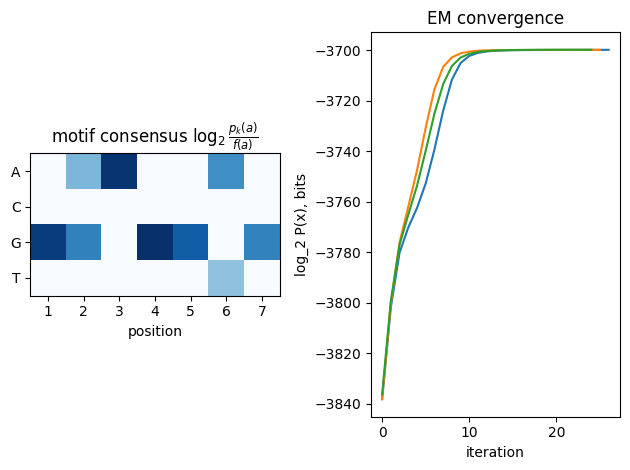

In [20]:
X1 = read_fasta('AluminumJesus-upstream.fa')

(motif1, bg1, logP, progress1) = multi_EM(rng, X1, W, n_tries)

visualize(motif1, bg1, progress1)

That's a consensus GGAGG, maybe GGAGG(a/t)G, against a ~60% GC background.

### HangryHippo

Motif probabilities:
[[0.563 0.114 0.163 0.16 ]
 [0.086 0.01  0.807 0.096]
 [0.09  0.012 0.875 0.023]
 [0.727 0.06  0.078 0.135]
 [0.13  0.028 0.693 0.149]
 [0.333 0.062 0.424 0.182]
 [0.384 0.155 0.269 0.191]]

Background probabilities:
[0.322 0.246 0.201 0.231]

Inferred motif has relative entropy of 4.80 bits


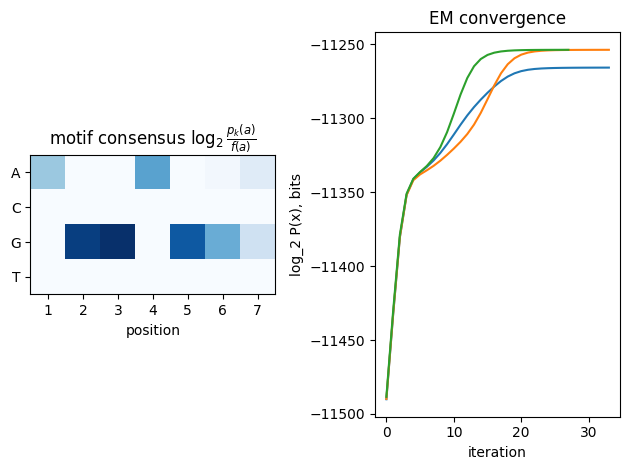

In [21]:
X2 = read_fasta('HangryHippo-upstream.fa')

(motif2, bg2, logP, progress2) = multi_EM(rng, X2, W, n_tries)

visualize(motif2, bg2, progress2)

That's a consensus GGAGG, against a ~45% GC background.

### T4

Motif probabilities:
[[0.332 0.061 0.483 0.123]
 [0.754 0.046 0.064 0.136]
 [0.037 0.    0.934 0.03 ]
 [0.113 0.008 0.817 0.062]
 [0.644 0.076 0.019 0.261]
 [0.418 0.065 0.254 0.262]
 [0.531 0.077 0.079 0.313]]

Background probabilities:
[0.385 0.138 0.123 0.354]

Inferred motif has relative entropy of 5.84 bits


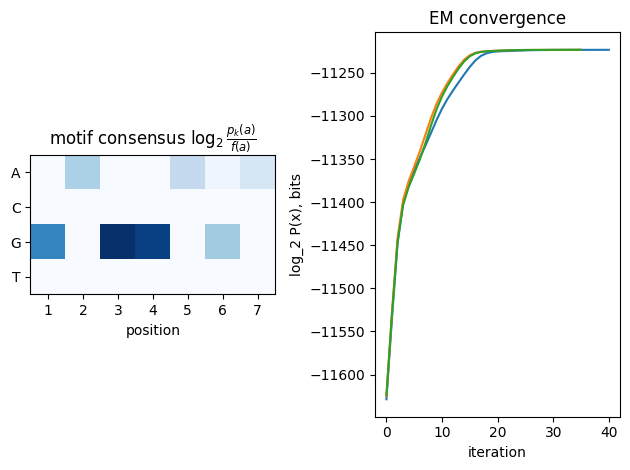

In [22]:
X3 = read_fasta('T4-upstream.fa')

(motif3, bg3, logP, progress3) = multi_EM(rng, X3, W, n_tries)

visualize(motif3, bg3, progress3)

That's a consensus GAGG, maybe GAGGAG if I'm generous, against a ~75% AT background. 

I think all those RBS consenses are essentially the same. Although these phage infect different hosts, bacterial ribosome binding sites are conserved broadly across species. If there's any difference, T4 might be a little different; maybe its high AT composition is driving the usual GGAGG central consensus to something a little less G-rich, toward GAGGA.

### closing formalities

In [23]:
%load_ext watermark
%watermark -v -m -p jupyter,numpy,matplotlib

Python implementation: CPython
Python version       : 3.12.5
IPython version      : 8.26.0

jupyter   : 1.0.0
numpy     : 2.1.0
matplotlib: 3.9.2

Compiler    : Clang 13.0.0 (clang-1300.0.29.30)
OS          : Darwin
Release     : 23.6.0
Machine     : x86_64
Processor   : i386
CPU cores   : 16
Architecture: 64bit

